In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Suppress division by 0 warning
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
class Converter:
    def __init__(self, max_power, k0, k1, k2, m0) -> None:
        self.max_power = max_power
        self.params = (k0, k1, k2, m0)

    def loss(self, power: float) -> float:
        k0, k1, k2, m0 = self.params
        max_power = self.max_power
        power_factor = np.abs(power) / max_power
        return (k0 * (1 - np.exp(-m0 * power_factor)) + k1 * power_factor + k2 * power_factor ** 2) * max_power
    
    def eff(self, power: float):
        loss = self.loss(power)
        return (np.abs(power) - loss) / np.abs(power) 

In [4]:
class Battery:
    def __init__(self, r : float, circuit: tuple[float, float], imax: tuple[float, float], vmax: tuple[float,float],) -> None:
        """
        imax: max discharge / charge current in A
        """
        self.r = r
        self.circuit = circuit
        self.imax = imax
        self.vmax = vmax

    def ocv_fit(self, soc) -> float:        
        a1 = 3.3479
        a2 = -6.7241
        a3 = 2.5958
        a4 = -61.9684
        b1 = 0.6350
        b2 = 1.4376
        k0 = 4.5868
        k1 = 3.1768
        k2 = -3.8418
        k3 = -4.6932
        k4 = 0.3618
        k5 = 0.9949

        return k0 + \
            k1 / (1 + np.exp(a1 * (soc - b1))) + \
            k2 / (1 + np.exp(a2 * (soc - b2))) + \
            k3 / (1 + np.exp(a3 * (soc - 1))) + \
            k4 / (1 + np.exp(a4 * soc)) + \
            k5 * soc

    def loss(self, power: float, soc: float) -> float:
        (serial, parallel) = self.circuit
        
        (imax_d, imax_c) = self.imax
        imax_d *= parallel
        imax_c *= parallel
        
        (vmin, vmax) = self.vmax
        vmin *= serial
        vmax *= serial

        ocv = self.ocv_fit(soc) * serial
        r = self.r * serial / parallel
        
        # Find the current that fulfills the power target `p`
        i = -(ocv - math.sqrt(ocv**2 + 4 * r * power)) / (2 * r)

        # check for current violations
        if i < imax_d or i > imax_c:
            return np.nan

        # check for voltage violations
        v = ocv + i * r
        if v < vmin or v > vmax:
            return np.nan
        
        # calculate losses
        return r * i **2

    def eff(self, power: float, soc: float):
        loss = self.loss(power, soc)
        return (np.abs(power) - loss) / np.abs(power) 

In [5]:
class System:
    def __init__(self, battery: Battery, converter: Converter) -> None:
        self.battery = battery
        self.converter = converter

    def loss(self, power: float, soc: float) -> float:
        loss_converter = self.converter.loss(power)
        power_battery = power - loss_converter
        loss_battery = self.battery.loss(power_battery, soc)
        return loss_converter + loss_battery
    
    def eff(self, power: float, soc: float):
        loss = self.loss(power, soc)
        return (np.abs(power) - loss) / np.abs(power) 

In [6]:
def plot_efficiency_curves(sys, soc=None, max_power=None, discharge=False):
    fig, ax = plt.subplots()
    ax.set_xlabel("Power in p.u.")
    ax.set_ylabel("Efficiency in %")
    ax.set_xlim(0, 1)
    ax.set_ylim(80, 100)

    # colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = plt.cm.tab20c

    if soc is None:
        soc = np.array([0.9, 0.5, 0.1])

    if max_power is None:
        max_power = sys.converter.max_power

    if discharge:
        max_power = -max_power

    power_factor = np.linspace(0, 1, 201) 
    power = power_factor * max_power

    for i, s in enumerate(soc):
        # loss = np.array([sys.loss(p, s) for p in power])
        # eff = (power - loss) / power * 100
        eff = np.array([sys.eff(p, s) for p in power]) * 100
        ax.plot(power_factor, eff, color=colors(i), label=f"{s:.0%}")
        
        eff_batt = np.array([sys.battery.eff(p, s) for p in power]) * 100
        ax.plot(power_factor, eff_batt, linestyle=":", color=colors(i), alpha=0.8)

    eff_conv = np.array([sys.converter.eff(p) for p in power]) * 100
    ax.plot(power_factor, eff_conv, linestyle="--", color="gray", alpha=0.8)
    
    ax.legend(title="SOC", loc="lower right")

    return fig

In [7]:
def plot_efficiency_contour(sys, max_power: float | None = None, discharge=False):
    fig, ax = plt.subplots()
    ax.set_facecolor("black") # show nan-values black

    if max_power is None:
        max_power : float = sys.converter.max_power

    if discharge:
        max_power = -max_power
    
    soc = np.linspace(0, 1, 101)
    power_factor = np.linspace(0, 1, 201) 
    power = power_factor * max_power

    eff = np.array([[sys.eff(p, s) for p in power] for s in soc])

    levels = [0.70, 0.80, 0.90, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 1.0]
    contourf = ax.contourf(power_factor, soc, eff, levels=levels, cmap="inferno", vmin=0.7, vmax=1.0)
    contour_lines = ax.contour(power_factor, soc, eff, levels=levels[0:1], colors="lightgray")
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
    contour_lines = ax.contour(power_factor, soc, eff, levels=levels[1:-1] , colors="black")
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
    # cbar = plt.colorbar(contourf)
    # cbar.set_label("Efficiency in p.u.")  # Optional: Add a label to the colorbar

    ax.set_xlabel("Power in p.u.")
    ax.set_ylabel("SOC in p.u.")

    return fig

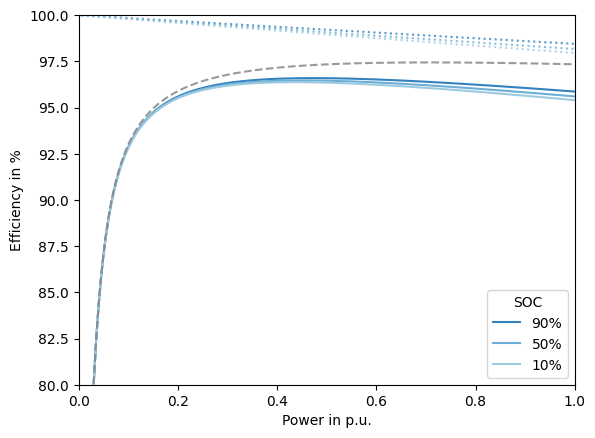

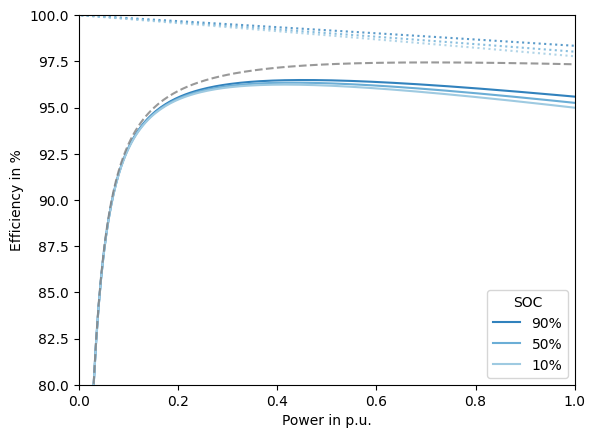

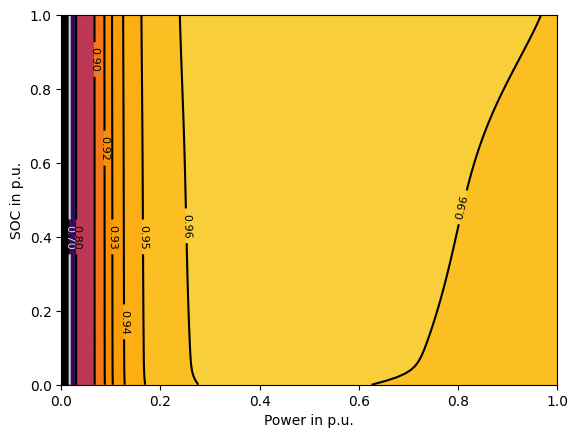

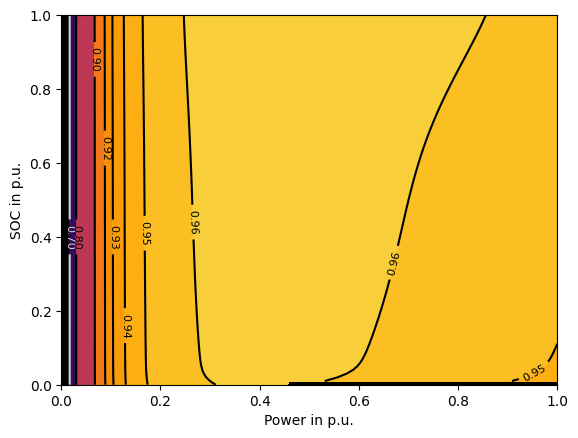

In [8]:
batt = Battery(r=0.75e-3, circuit=(260, 2), imax=(-200, 200), vmax=(3.2, 4.2))

converter_params = {"k0": 0.00601144, "k1": 0.00863612, "k2": 0.01195589, "m0": 100}
acdc = Converter(max_power=180e3, **converter_params)

sys = System(battery=batt, converter=acdc)

fig = plot_efficiency_curves(sys)
fig = plot_efficiency_curves(sys, discharge=True)
fig = plot_efficiency_contour(sys)
fig = plot_efficiency_contour(sys, discharge=True)

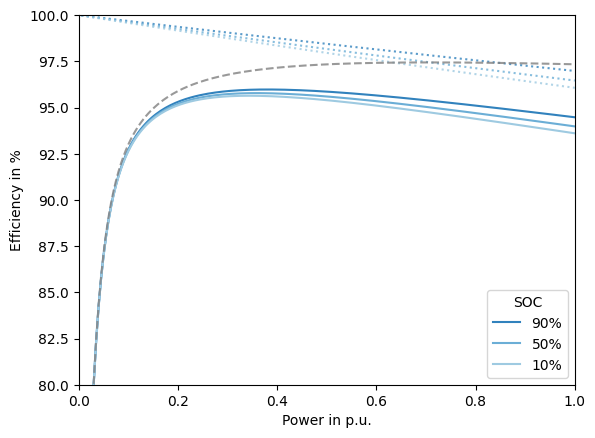

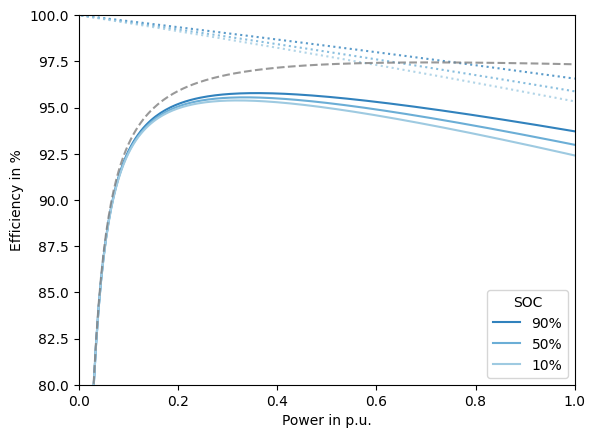

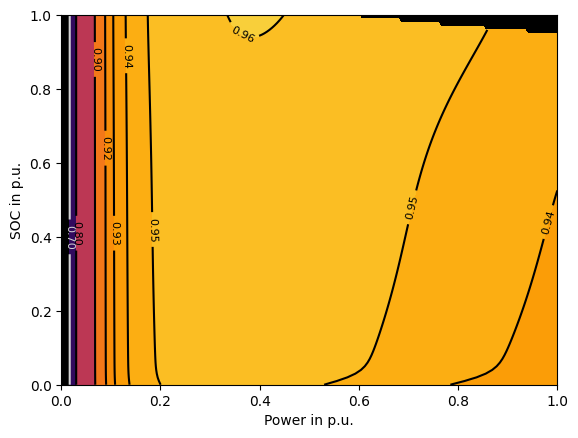

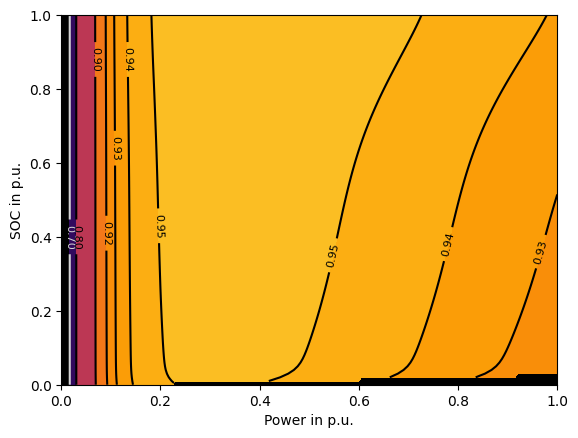

In [9]:
batt = Battery(r=1.5e-3, circuit=(260, 2), imax=(-200, 200), vmax=(3.2, 4.2))
sys = System(battery=batt, converter=acdc)

fig = plot_efficiency_curves(sys)
fig = plot_efficiency_curves(sys, discharge=True)
fig = plot_efficiency_contour(sys)
fig = plot_efficiency_contour(sys, discharge=True)

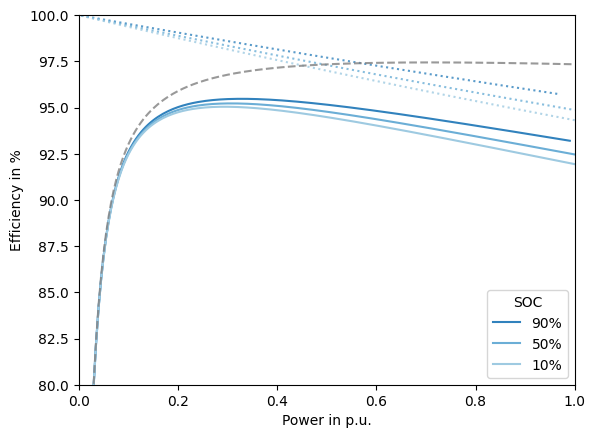

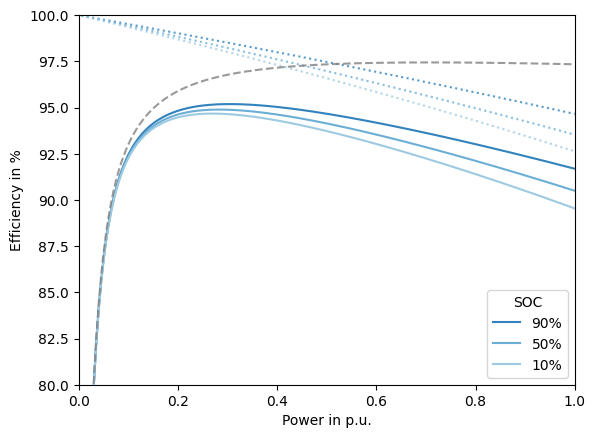

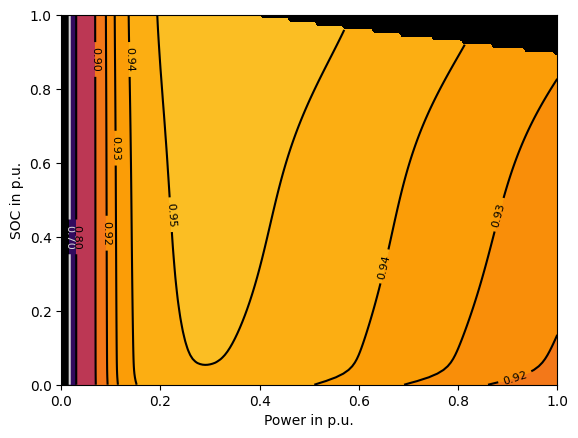

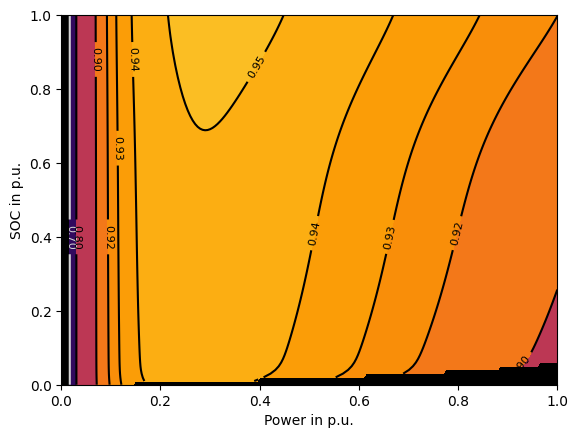

In [10]:
batt = Battery(r=3 * 0.75e-3, circuit=(260, 2), imax=(-200, 200), vmax=(3.2, 4.2))
sys = System(battery=batt, converter=acdc)

fig = plot_efficiency_curves(sys)
fig = plot_efficiency_curves(sys, discharge=True)
fig = plot_efficiency_contour(sys)
fig = plot_efficiency_contour(sys, discharge=True)